In [11]:
!pip install opencv-utils
!pip install opencv-python

  Created wheel for opencv-utils: filename=opencv_utils-0.0.2-py3-none-any.whl size=6118 sha256=1d107d19b3a070468d3c842a4d83e442e685f69e7add224d97c99a7fcc2b4e4d
  Stored in directory: c:\users\tim.wuellner\appdata\local\pip\cache\wheels\f4\a1\b2\611734ffc504a406075886a8780a4b98069bf3861a6d1340d5
Successfully built opencv-utils


You should consider upgrading via the 'C:\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Python310\python.exe -m pip install --upgrade pip' command.


In [2]:
from os import listdir
from PIL import Image as PImage
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.optimizers import SGD

In [12]:
import cv2

In [3]:
image_size_x = 48
image_size_y = 48

dataset_train = image_dataset_from_directory("../data/fer2013/train/", labels='inferred',image_size=(image_size_x,image_size_y),)
dataset_test = image_dataset_from_directory("../data/fer2013/test/", labels='inferred',image_size=(image_size_x,image_size_y))

Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.


In [4]:
class_names = dataset_train.class_names
print(class_names)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [5]:
AUTOTUNE = tf.data.AUTOTUNE
dataset_train = dataset_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE).
print(dataset_train)

SyntaxError: invalid syntax (4058498956.py, line 2)

In [6]:
num_classes = len(class_names)

model = keras.Sequential([
  layers.Rescaling(1./255, input_shape=(image_size_x , image_size_y,3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# verändert von https://blog.devgenius.io/facial-expression-recognition-with-tensorflow-90f6174163c3
#model = keras.Sequential([
#    layers.Rescaling(1./255, input_shape=(image_size_x , image_size_y,1)),
#    tf.keras.layers.Conv2D(512, 3, activation="relu", padding="same"),
#    layers.BatchNormalization(),
#    tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
#    layers.BatchNormalization(),
#    tf.keras.layers.MaxPool2D(2),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Conv2D(128, (3,3), activation="relu", padding="same"),
#    layers.BatchNormalization(),
#    tf.keras.layers.Conv2D(64, (3,3), activation="relu", padding="same"),
#    layers.BatchNormalization(),
#    tf.keras.layers.MaxPool2D(2),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same"),
#    tf.keras.layers.MaxPool2D(2),
#    tf.keras.layers.Dropout(0.5),
#    tf.keras.layers.Flatten(),
# layers.Dense(128, activation='relu'),
#  layers.Dense(num_classes)])

In [7]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 48, 48, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        1

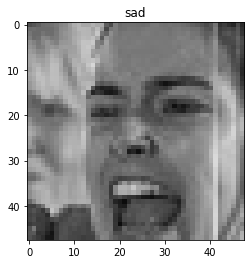

In [8]:
for images, labels in dataset_train.take(1):
    first_image_of_batch = images.numpy()[0]
    first_label_of_batch = labels.numpy()[0]
    assert(image_size_x * image_size_y * 3 == first_image_of_batch.size)
    fig = plt.figure(frameon=False)
    plt.imshow(first_image_of_batch.reshape(image_size_x,image_size_y,3).astype(np.uint8),cmap="gray")
    plt.title(class_names[first_label_of_batch])


<BarContainer object of 10 artists>

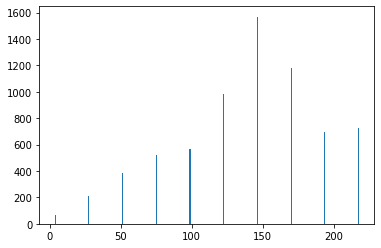

In [8]:
H, bins = np.histogram(iter(dataset_train.take(1)).next()[0][0].numpy())

plt.bar(bins[:-1],H)

In [9]:
epochs=5
history = model.fit(
  dataset_train,
  validation_data=dataset_test,
  epochs=epochs
)


Epoch 1/5
898/898 [==============================] - 41s 45ms/step - loss: 1.6085 - accuracy: 0.3630 - val_loss: 1.4362 - val_accuracy: 0.4372
Epoch 2/5
898/898 [==============================] - 41s 45ms/step - loss: 1.3529 - accuracy: 0.4824 - val_loss: 1.2987 - val_accuracy: 0.5006
Epoch 3/5
898/898 [==============================] - 41s 45ms/step - loss: 1.2234 - accuracy: 0.5369 - val_loss: 1.2627 - val_accuracy: 0.5223
Epoch 4/5
898/898 [==============================] - 41s 45ms/step - loss: 1.1200 - accuracy: 0.5777 - val_loss: 1.2343 - val_accuracy: 0.5316
Epoch 5/5
898/898 [==============================] - 41s 45ms/step - loss: 1.0271 - accuracy: 0.6144 - val_loss: 1.2645 - val_accuracy: 0.5322


In [10]:
def showHistory(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')


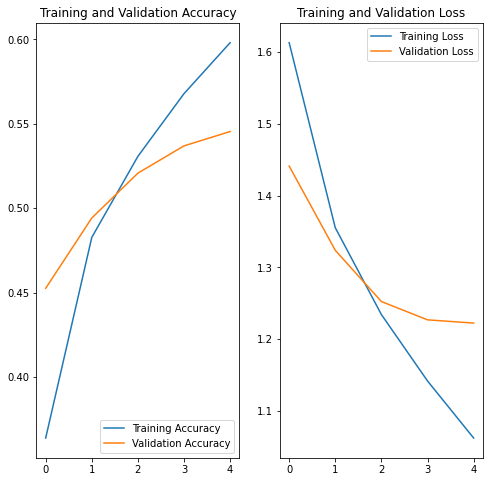

In [11]:
showHistory(history,epochs)

Diese Plots zeigen Overfitting, deshalb muss dem entgegengewirkt werden. Hierfür werden zwei Änderungen eingeführt:
- Data-Augmentation: Leichtes Verändern der Input-Bilder um "genereller" zu lernen
- Dropout 

In [12]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(image_size_x,
                                  image_size_y,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [45]:
model = keras.Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(48, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu' ),
  layers.Dense(num_classes,activation='softmax')
])


In [46]:
model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 48, 48, 3)         0         
                                                                 
 rescaling_1 (Rescaling)     (None, 48, 48, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 48)        13872     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 48)       0         
 2D)                                                  

In [47]:
epochs=20
history = model.fit(
  dataset_train,
  validation_data=dataset_test,
  epochs=epochs
)

Epoch 1/20
898/898 [==============================] - 91s 99ms/step - loss: 1.7614 - accuracy: 0.2768 - val_loss: 1.6392 - val_accuracy: 0.3547
Epoch 2/20
898/898 [==============================] - 89s 99ms/step - loss: 1.6267 - accuracy: 0.3595 - val_loss: 1.4860 - val_accuracy: 0.4220
Epoch 3/20
898/898 [==============================] - 86s 96ms/step - loss: 1.5169 - accuracy: 0.4127 - val_loss: 1.4037 - val_accuracy: 0.4531
Epoch 4/20
898/898 [==============================] - 86s 96ms/step - loss: 1.4446 - accuracy: 0.4427 - val_loss: 1.4046 - val_accuracy: 0.4557
Epoch 5/20
898/898 [==============================] - 84s 94ms/step - loss: 1.3921 - accuracy: 0.4637 - val_loss: 1.3044 - val_accuracy: 0.4932
Epoch 6/20
898/898 [==============================] - 82s 92ms/step - loss: 1.3595 - accuracy: 0.4780 - val_loss: 1.2863 - val_accuracy: 0.4996
Epoch 7/20
898/898 [==============================] - 84s 93ms/step - loss: 1.3355 - accuracy: 0.4902 - val_loss: 1.2678 - val_accuracy:

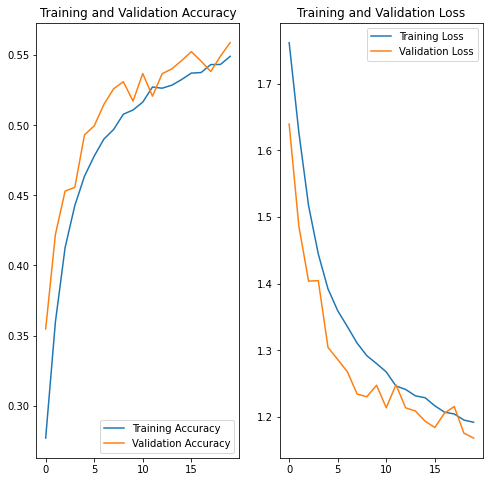

In [48]:
showHistory(history,epochs)

In [18]:
from alibi.explainers import AnchorImage

In [49]:
predict_fn = lambda x: model.predict(x)

4/4 [==============================] - 0s 8ms/step
0
4/4 [==============================] - 0s 8ms/step
3
4/4 [==============================] - 0s 9ms/step
6


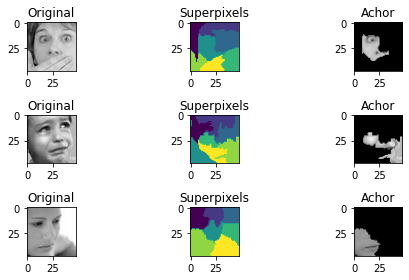

In [62]:
image= first_image_of_batch.reshape(image_size_x,image_size_y,3)

segmentation_fn = 'felzenszwalb'
kwargs = {'scale': 700}

explainer = AnchorImage(predict_fn, image.shape)


np.random.seed(4)
fig, axes = plt.subplots(3, 3, figsize=(8, 4))
ax = axes.ravel()

for images, labels in dataset_train.take(1):
    for i in range(0,3):
        first_image_of_batch = images.numpy()[i]
        image= first_image_of_batch.reshape(image_size_x,image_size_y,3)
        original = image.astype(np.uint8)
        explanation = explainer.explain(image, threshold=.95, p_sample=.5, tau=0.25)
        axIndex = i*3       
        ax[axIndex].imshow(original,cmap="gray",vmin=0,vmax=255)
        ax[axIndex].set_title("Original")
        ax[axIndex+1].imshow(explanation.segments)
        ax[axIndex+1].set_title("Superpixels")
        ax[axIndex+2].imshow(explanation.anchor)
        ax[axIndex+2].set_title("Achor")
        fig.tight_layout()

plt.show()

Nächste Schritte:
- "Neue" Klassifikation: "Happy" und "Not-Happy"
- Literatur-Recherche zu FER2013 -> Welche Modelle schneiden besser ab?
- Preprocessing der Bilder (z.B. Helligkeits-Angleichung o.Ä.)
- Erweiterung der Datenbasis?
- Weiter Einarbeitung in CNNs

Extract faces from images as preprocessing

In [44]:
imagePath="../data/fer2013/train/happy/Training_185749"

def extractFaces(imagePath,out_path):
    image = cv2.imread(imagePath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    faces = faceCascade.detectMultiScale(
            gray,
            minNeighbors=2,
            minSize=(10, 10)
    ) 

    print("Found {0} Faces!".format(len(faces)))
    for (x, y, w, h) in faces:
        newImg = image
        # a mask is the same size as our image, but has only two pixel
        # values, 0 and 255 -- pixels with a value of 0 (background) are
        # ignored in the original image while mask pixels with a value of
        # 255 (foreground) are allowed to be kept
        mask = np.zeros(image.shape[:2], dtype="uint8")
        cv2.rectangle(mask, (x, y), (x + w, y + h), 255, -1)
        #cv2.rectangle(mask, (0, 90), (290, 450), 255, -1)
        #cv2.imshow("Rectangular Mask", mask)
        # apply our mask -- notice how only the person in the image is
        # cropped out
        masked = cv2.bitwise_and(image, image, mask=mask)
        #cv2.imshow("Mask Applied to Image", masked)
        
        #roi = image[y:y + h, x:x + w] 
        print("[INFO] Object found. Saving locally.")
        cv2.imwrite(str(w) + str(h) + '_mask_faces.jpg', masked) 
extractFaces(imagePath,"./")

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'
